<a href="https://colab.research.google.com/github/rik03/CarDekho-Analysis/blob/main/Copy_of_CarDekho_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis on CarDekho Dataset

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('drive/MyDrive/ML Projects/CarDekho-Analysis/Car details v3.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [5]:
carset = df.set_index('name')
carset

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
name,,,,,,,,,,,,
Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0


In [6]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In this dataset we look to predict the selling_price based on the various measures and factors provided. We will try to fit a model which helps us to do the same.

In [7]:
carset.columns

Index(['year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In [8]:
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [9]:
df=df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7906 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           7906 non-null   object 
 1   year           7906 non-null   int64  
 2   selling_price  7906 non-null   int64  
 3   km_driven      7906 non-null   int64  
 4   fuel           7906 non-null   object 
 5   seller_type    7906 non-null   object 
 6   transmission   7906 non-null   object 
 7   owner          7906 non-null   object 
 8   mileage        7906 non-null   object 
 9   engine         7906 non-null   object 
 10  max_power      7906 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7906 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 864.7+ KB


In [13]:
print(df.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
8121    False
8122    False
8123    False
8124    False
8125    False
Length: 6717, dtype: bool


In [12]:
df = df.drop_duplicates()

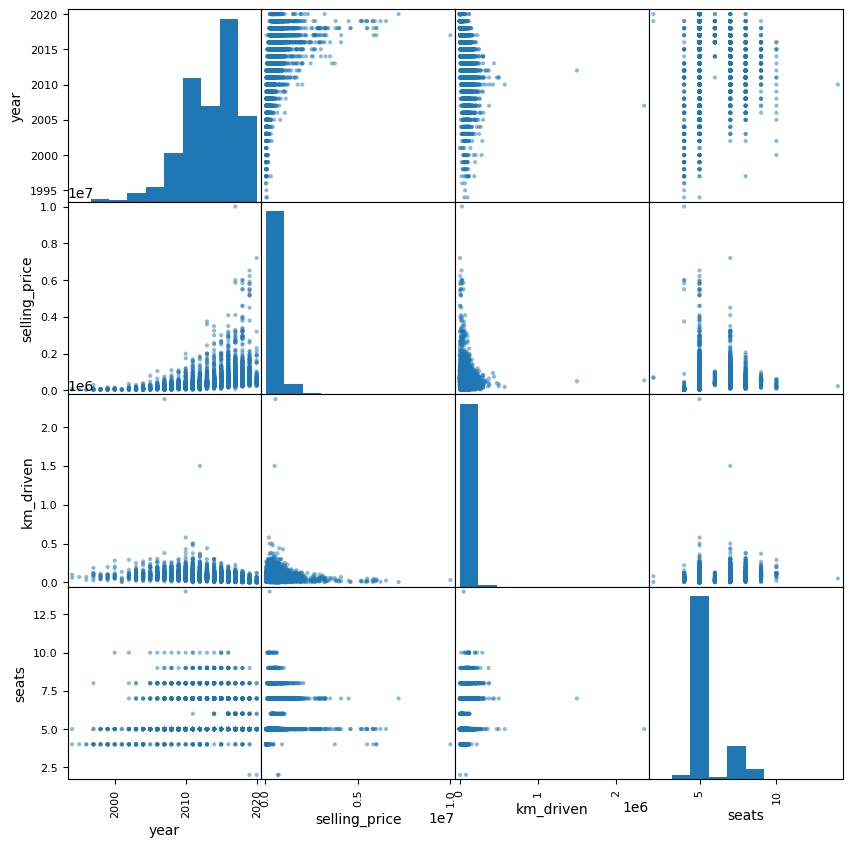

In [14]:
pd.plotting.scatter_matrix(df[['year','selling_price','km_driven','seats']], figsize=(10,10));

In [15]:
df.describe()

,year,selling_price,km_driven,seats
count,6717.000000,6.717000e+03,6.717000e+03,6717.000000
mean,2013.611136,5.263860e+05,7.339834e+04,5.434271
std,3.897402,5.235504e+05,5.870328e+04,0.983805
min,1994.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.500000e+05,3.800000e+04,5.000000
50%,2014.000000,4.200000e+05,6.820300e+04,5.000000
75%,2017.000000,6.500000e+05,1.000000e+05,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [16]:
df.fuel = pd.Series(df.fuel, dtype='category')
df.seller_type = pd.Series(df.seller_type, dtype='category')
df.transmission	=pd.Series(df.transmission, dtype='category')
df.owner	= pd.Series(df.owner, dtype='category')
df.fuel.dtype
df.seller_type.dtype
df.transmission.dtype
df.owner.dtype

CategoricalDtype(categories=['First Owner', 'Fourth & Above Owner', 'Second Owner',
                  'Test Drive Car', 'Third Owner'],
, ordered=False)

In [17]:
df['fuel'].unique()

['Diesel', 'Petrol', 'LPG', 'CNG']
Categories (4, object): ['CNG', 'Diesel', 'LPG', 'Petrol']

In [18]:
df = pd.concat([df.drop('fuel',axis=1),pd.get_dummies(df.fuel, drop_first=True)],axis=1)
df = pd.concat([df.drop('seller_type',axis=1),pd.get_dummies(df.seller_type, drop_first=True)],axis=1)
df = pd.concat([df.drop('transmission',axis=1),pd.get_dummies(df.transmission, drop_first=True)],axis=1)
df = pd.concat([df.drop('owner',axis=1),pd.get_dummies(df.owner, drop_first=True)],axis=1)

In [19]:
df.head()

,name,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,Diesel,LPG,Petrol,Individual,Trustmark Dealer,Manual,Fourth & Above Owner,Second Owner,Test Drive Car,Third Owner
0,Maruti Swift Dzire VDI,2014,450000,145500,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,1,0,0,1,0,1,0,0,0,0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,1,0,0,1,0,1,0,1,0,0
2,Honda City 2017-2020 EXi,2006,158000,140000,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,0,0,1,1,0,1,0,0,0,1
3,Hyundai i20 Sportz Diesel,2010,225000,127000,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0,1,0,0,1,0,1,0,0,0,0
4,Maruti Swift VXI BSIII,2007,130000,120000,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,0,0,1,1,0,1,0,0,0,0


In [20]:
df['mileage'] =  df['mileage'].str.extract('(\d+\.\d+)').astype(float)
df['engine'] =  df['engine'].str.extract('(\d+)').astype(int)
#df['max_power'] =  df['max_power'].str.extract('(r"[-+]?(?:\d*\.*\d+)")').astype(float)
df.head()

,name,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,Diesel,LPG,Petrol,Individual,Trustmark Dealer,Manual,Fourth & Above Owner,Second Owner,Test Drive Car,Third Owner
0,Maruti Swift Dzire VDI,2014,450000,145500,23.40,1248,74 bhp,190Nm@ 2000rpm,5.0,1,0,0,1,0,1,0,0,0,0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,21.14,1498,103.52 bhp,250Nm@ 1500-2500rpm,5.0,1,0,0,1,0,1,0,1,0,0
2,Honda City 2017-2020 EXi,2006,158000,140000,17.70,1497,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,0,0,1,1,0,1,0,0,0,1
3,Hyundai i20 Sportz Diesel,2010,225000,127000,23.00,1396,90 bhp,22.4 kgm at 1750-2750rpm,5.0,1,0,0,1,0,1,0,0,0,0
4,Maruti Swift VXI BSIII,2007,130000,120000,16.10,1298,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,0,0,1,1,0,1,0,0,0,0


In [21]:
# Checking for the significance of fuel type
m_fuel = ols('selling_price ~ Petrol + LPG + Diesel',data=df).fit()
print(m_fuel.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     156.1
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           8.58e-98
Time:                        19:11:07   Log-Likelihood:                -97756.
No. Observations:                6717   AIC:                         1.955e+05
Df Residuals:                    6713   BIC:                         1.955e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.177e+05   7.09e+04      4.481      0.0

In [22]:
m_fuel = ols('selling_price ~ Petrol + LPG',data=df).fit()
print(m_fuel.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     222.7
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           2.18e-94
Time:                        19:11:10   Log-Likelihood:                -97767.
No. Observations:                6717   AIC:                         1.955e+05
Df Residuals:                    6714   BIC:                         1.956e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.435e+05   8326.155     77.281      0.0

**Interpretation** :

Here we see that when we take only three of the fuel types we see they all are insignificant in the presence of other, but when we take all four of them we see a increse in the p values of all of them. We see them become insignificant because we know that,

CNG + LPG + Petrol + Diesel = 1(always).

Also we see that they are negatively correlated with the price.